In [1]:
import sys 
import os
sys.path.append('/home/hrc2cloud/distopia_agents')

from threading import Thread
from agents.bfilter import BayesFilter
from agents.utils import hierarchical_sort, str2arr
from agents.plot_hist import plot_hist
from copy import deepcopy
from random import shuffle

import json
import numpy as np
import pickle as pkl
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from multiprocessing import Pool, Queue
from tqdm import tqdm, tqdm_notebook, tnrange

In [2]:
# set filenames
# data we're standardizing on (from the one-hots)
# standardization_f = 'resources/stripped_normalization.pkl'
one_hot_norm_f = "resources/five_norms_raw.pkl"

# training data for kdes, this should be a dict of metrics keyed on task
training_f = 'resources/243_raw_data.pkl' 

# test data for kdes. this includes the task, metrics, and beliefs
test_f ='results/results_file_full_243_run0_90_each'



In [3]:
# # load the standardization params from standardization_f
# with open(standardization_f,'rb') as sfile:
#     standard_m, standard_std = pkl.load(sfile)
#     standard_m = standard_m[:-1]
#     standard_std = standard_std[:-1]
# print(standard_m.shape,standard_std.shape)
# print(standard_m,standard_std)

# load the standardization params from the one_hot_norm_f
with open(one_hot_norm_f, 'rb') as infile:
    data_dict = pkl.load(infile)[0]
    values = np.concatenate(list(data_dict.values()))
    standard_m = np.mean(values,0)
    standard_std = np.std(values, 0)

print(standard_m.shape,standard_std.shape)
print(standard_m,standard_std)
    

(5,) (5,)
[7.15517019e+05 1.31924818e+05 2.15646375e-01 4.19299239e-01
 7.05841705e-02] [2.15629717e+05 5.81501466e+04 6.43620508e-02 2.34225926e-02
 2.97042249e-02]


In [4]:
def metric_standardize(data, m, std, transform=None):
    return (data - m)/std

In [5]:

# load the training data
with open(training_f, 'rb') as trainfile:
    training_dict = pkl.load(trainfile)[0]


In [6]:
# split data into train and test sets

def prepare_data(data_dict, test_ratio = 0.2, reshuffle_trajectories = False, verbose = False):
#     dictionaries of training and testing data, {key: task label, value: trajectory}
    train_data = {}
    test_data = {}
    
    for label, flattened_trajectories in data_dict.items():
        total_steps,_ = flattened_trajectories.shape
        # total number of trajectories for each task
        num_trajectories = int(total_steps / 100)
        if total_steps % 100 != 0:
            num_trajectories += 1
        
        # number of train and test examples
        n_test = int(num_trajectories * test_ratio)
        n_train = num_trajectories - n_test
        
        # indicies for training, the remainder are for testing
        indices = []
        if(reshuffle_trajectories):
            indicies = list(range(num_trajectories))
            shuffle(indicies)
        else:
            with open("resources/shuffle_indicies.pk","rb") as infile:
                indices = pkl.load(infile)
                
        train_i = set(indicies[:n_train])
        
        # initial values for dicts
        train_data[label] = []
        test_data[label] = []
        
        # add trajectories to the relevant dicts
        for i in range(num_trajectories):
            if i in train_i:
                # get trajectory
                trajectory = flattened_trajectories[(i*100):min((i+1)*100,total_steps)]
                train_data[label].append(trajectory)
            else:
                trajectory = flattened_trajectories[(i*100):min((i+1)*100,total_steps)]
                test_data[label].append(trajectory)
        
        # flatten training
        train_data[label] = np.concatenate(train_data[label])
        
        # print mean and stds of the splits
        if verbose:
            print("Training Data mean: {} std_dec: {}".format(np.mean(train_data[label],0),np.std(train_data[label],0)))
            print("Testing Data mean: {} std_dec: {}".format(np.mean(test_data[label],0),np.std(test_data[label],0)))

    return train_data, test_data

In [68]:
with open("resources/shuffle_indicies.pk","wb+") as outfile:
    pkl.dump(indicies, outfile)

NameError: name 'indicies' is not defined

In [7]:
train_data_dict, test_data_dict = prepare_data(training_dict)

In [54]:
# prepare the kde_dict
kde_dict = {}
for task, task_data in train_data_dict.items():
    task_str = str(np.array(eval(task)))
    task_kde = KernelDensity(kernel = 'gaussian', bandwidth=0.2).fit(metric_standardize(task_data, standard_m, standard_std))
    kde_dict[task_str] = task_kde #task_obs_fun

# generate tasks
tasks = list(map(np.array,itertools.product([-1., 0., 1.], [-1., 0., 1.], [-1., 0., 1.], [-1., 0., 1.], [-1., 0., 1.])))
# tasks = []
task_strings = {str(task): task for task in tasks}
task_strings = list(map(str2arr, task_strings))
task_strings = list(map(str, hierarchical_sort(task_strings)))
task_dict = {tstr : str2arr(tstr) for tstr in task_strings}    

task_neighborhood_size_dict = {}
for tstr in task_strings:
    task_arr = task_dict[tstr]
    num_neighbors = 0
    for metric in task_arr:
        if metric == 0:
            num_neighbors += 2
        elif metric == -1 or metric == 1:
            num_neighbors += 1
        else:
            raise ValueError("metric was not in {-1, 0, 1}")
    task_neighborhood_size_dict[tstr] = num_neighbors

zero_prob = 1/243
low_prob = 22/243
high_prob = 220/243

def t_func(task_from, task_to, action):
    t0 = task_dict[task_from]
    t1 = task_dict[task_to]
    diff = np.linalg.norm(t1-t0,1) # get the 1-norm difference (sum of abs values of elements)
    # if more than 1 away, prob is 1/243
    if diff > 1:
        return zero_prob/(243-task_neighborhood_size_dict[task_from]-1) #uniformly distribute over the non-neighbors
    elif diff == 1:
        return low_prob/(task_neighborhood_size_dict[task_from])
    elif diff == 0:
        return high_prob # only one of these
    else:
        raise(ValueError("There is something wrong with the norm, got a negative l1 norm for {} and {}".format(t0,t1)))

def o_func(observation,task):
    return np.exp(kde_dict[str(task)].score(observation.reshape(1,len(observation))))

In [55]:
print(list(kde_dict.keys())[:5])

['[-1. -1. -1. -1. -1.]', '[-1. -1. -1. -1.  0.]', '[-1. -1. -1. -1.  1.]', '[-1. -1. -1.  0. -1.]', '[-1. -1. -1.  0.  0.]']


In [56]:
b = BayesFilter(task_strings,t_func,o_func)

In [57]:
# Results queue
RESULTS_QUEUE = Queue()
# Status queue
STATUS_QUEUE = Queue() 

def filter_trajectory(trajectory_tuples):
    # tuples are (trajectory, label)
    trajectory, label = trajectory_tuples
    print(len(trajectory))
    targets = []
    targets_append = targets.append
    predictions = []
    predictions_append = predictions.append
    bf = BayesFilter(task_strings,t_func,o_func)
    for step in trajectory:
        #belief_star = bf.prediction_step(action=None)
        standardized_step = metric_standardize(step, standard_m, standard_std)
        belief = deepcopy(bf.observation_step(standardized_step))
        prediction = max(belief, key=lambda x :belief[x])
        # get the second max instead
#         belief.pop(prediction)
#         prediction = max(belief, key=lambda x :belief[x])
#         belief.pop(prediction)
#         prediction = max(belief, key=lambda x :belief[x])
        ####
        #print("Target: {}, Prediction: {}".format(label,prediction))
        targets_append(label)
        predictions_append(prediction)
        STATUS_QUEUE.put(1)
    #RESULTS_QUEUE.put((targets, predictions))
    return targets, predictions

def progress_monitor(n_steps):
    for i in tqdm_notebook(range(n_steps)):
        STATUS_QUEUE.get()

In [58]:
RESULTS_QUEUE = Queue()
STATUS_QUEUE = Queue()

# transform the test_data_dict into a list of tuples of the format: (trajectory, task_label)
input_arr = []
for task_label, trajectories in test_data_dict.items():
    for trajectory in trajectories:
        input_arr.append((trajectory, task_label))

thread = Thread(target=progress_monitor, args=(len(input_arr)*100,))
thread.start()
print("starting")
results = None
with Pool(24) as pool:
        results = pool.map(filter_trajectory, input_arr)

starting


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


100
100
100
100
100
100
100
100
87
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
1

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


In [72]:
len(results[0])

2

In [ ]:
# # targets = []
# # predictions = []
# # targets_append = targets.append
# # predictions_append = predictions.append
# while RESULTS_QUEUE.qsize() != 0:
#     print("popping")
#     traj_targets, traj_predictions = RESULTS_QUEUE.get()
#     for t in traj_targets:
#         targets_append(t)
#     for p in traj_predictions:
#         predictions_append(p)

In [60]:
targets,predictions = zip(*results)

In [61]:
targets = np.concatenate(targets)
predictions = np.concatenate(predictions)


In [65]:
with open("resources/new_targets_dump.pkl","wb+") as outfile:
    pkl.dump(targets, outfile)
with open("resources/new_predictions_dump.pkl","wb+") as outfile:
    pkl.dump(predictions, outfile)

In [80]:
targets[0]

'[-1.0, -1.0, -1.0, -1.0, -1.0]'

In [ ]:
# targets = []
# predictions = []
# targets_append = targets.append
# predictions_append = predictions.append
# for i,trajectory in enumerate(test_trajectories):
#     b = BayesFilter(task_strings,t_func,o_func)
#     for step in trajectory:
#         standardized_step = metric_standardize(step, test_m, test_std)
#         belief = b.observation_step(standardized_step)
#         prediction = max(belief, key=lambda x :belief[x])
#         #print("Target: {}, Prediction: {}".format(test_labels[i],prediction))
#         targets_append(test_labels[i])
#         predictions_append(prediction)

In [78]:
simple_accuracy = sum([1 if prediction == targets[i] else 0 for i,prediction in enumerate(predictions)])
print("Simple_Accuracy: {}/{} = {}".format(simple_accuracy,len(predictions),simple_accuracy/len(predictions)))

Simple_Accuracy: 0/422322 = 0.0


In [342]:
cm = confusion_matrix(targets, predictions, labels=task_strings)

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.75 0.25
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]


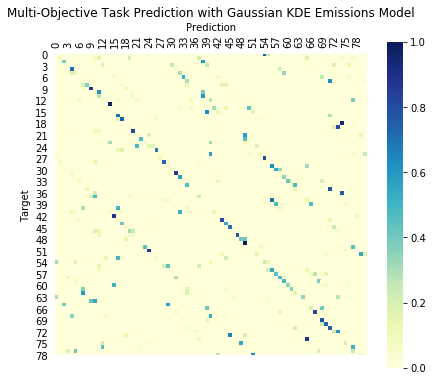

In [343]:
fig = plt.figure(figsize=(7, 6))
xmin = 0 #192
xmax = len(task_str) #218
ymin = 0 #110
ymax = len(task_str) #137
cm = cm.astype(float)
for row in range(cm.shape[0]):
    tot_freq = np.sum(cm[row, :])
    cm[row,:] = cm[row,:]/tot_freq
print(cm[0, :])
#sns.heatmap(cm, cmap='YlGnBu', square=1, annot=True, fmt="d", linewidths=1, xticklabels=task_names, yticklabels=task_names)
sns.heatmap(cm, cmap='YlGnBu', square=1)
#sns.heatmap(cm[ymin:ymax, xmin:xmax], cmap='YlGnBu', square=1, annot=False, xticklabels=task_names[xmin:xmax], yticklabels=task_names[ymin:ymax])
ax = plt.gca()
ax.xaxis.tick_top()
ax.tick_params(axis="x", rotation=90)
ax.tick_params(width=0)
ax.xaxis.set_label_position('top')
# plt.xticks(np.arange(len(task_names)), task_names, rotation=90)
#plt.xlim(0, len(task_names))
#plt.yticks(np.arange(len(task_names)), task_names, rotate=90)
#plt.ylim(len(task_names), 0)  # inverted range for "upper" origin
plt.ylabel('Target')
plt.xlabel('Prediction')
plt.title('Multi-Objective Task Prediction with Gaussian KDE Emissions Model')
plt.show()


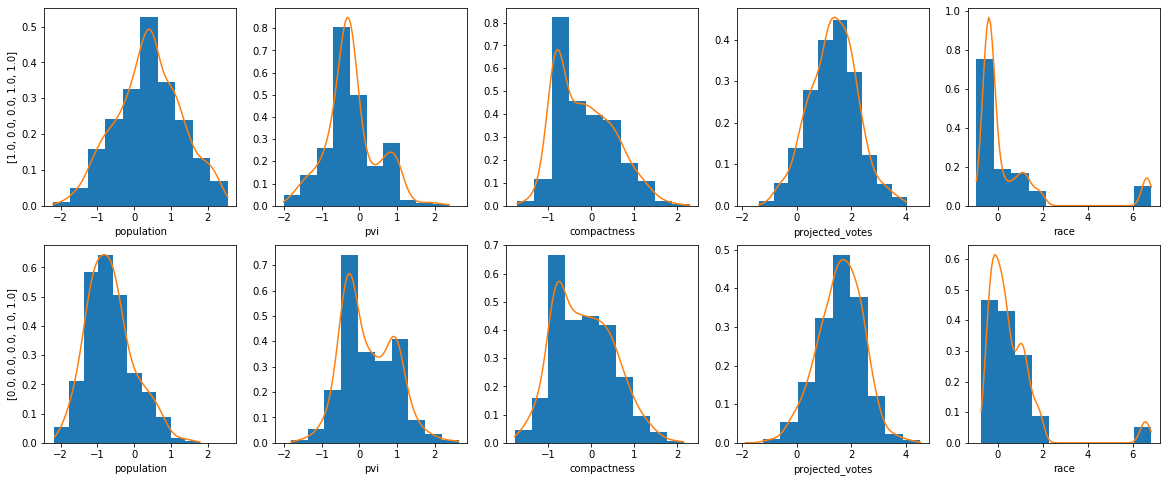

In [43]:
import agents.plot_hist
agents.plot_hist.plot_hist(train_data_dict,['[1.0, 0.0, 0.0, 1.0, 1.0]','[0.0, 0.0, 0.0, 1.0, 1.0]'], transform=None, pop_m=standard_m,pop_std=standard_std)

In [387]:
np.exp(kde_dict[str(np.array([1., 0., 0., 0.]))].score([[2,-0.5,1.1,1.1]]))

1.6534469595286814e-05

In [377]:
np.exp(kde_dict[str(np.array([0., 0., 1., 1.]))].score([[0.5,-0.5,1.1,1.1]]))

0.1498851434773772

In [347]:
import importlib
import sys
importlib.reload(sys.modules['agents.plot_hist'])

<module 'agents.plot_hist' from '/home/dev/PycharmProjects/distopia_agents/agents/plot_hist.py'>

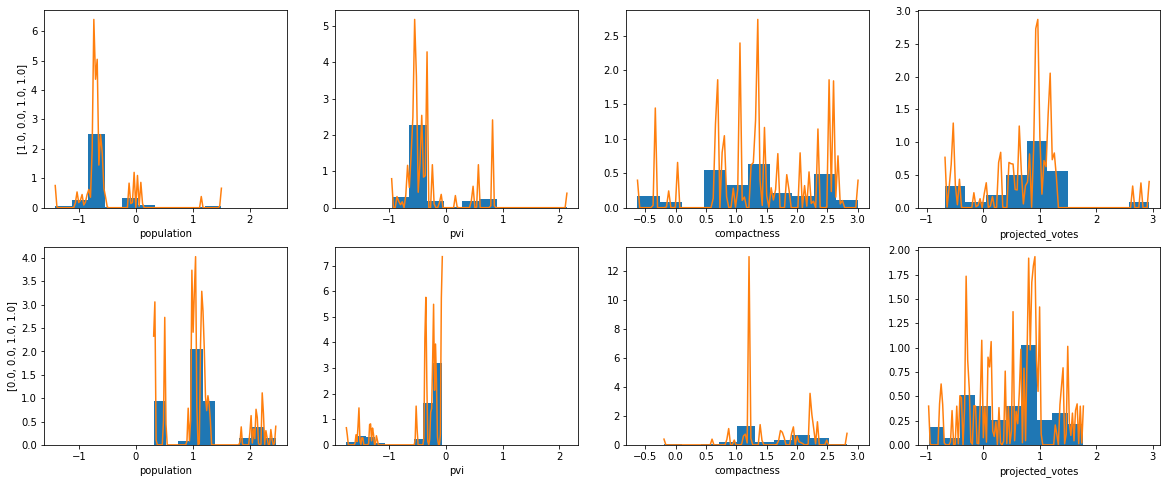

In [192]:
agents.plot_hist.plot_hist(abbreviations_dict,[str([1.0, 0.0, 1.0, 1.0]),str([0.0, 0.0, 1.0, 1.0])], pop_m=standard_m,pop_std=standard_std)